# ISSM "square ice shelf" tutorial (with moving front)

Based off of square ice shelf tutorial, but incorporating a moving front. 

## Imports

In [1]:
########################
### "normal" imports ###
########################

import numpy as np
import matplotlib.pyplot as plt
from shapely import LineString
from shapely.geometry import Point, Polygon
import tqdm

######################
### ISSM functions ###
######################

from model import model
from squaremesh import squaremesh

################
### my stuff ###
################

from issm_helper import *

## Initialize model and mesh domain

In [2]:
md = model()
Lx, Ly = 1e6, 1e6
md = squaremesh(md, Lx, Ly, 50, 50) #squaremesh(model, x, y, nx, ny)

## Describe boundaries and levelsets

ISSM needs to know which parts of the domain are grounded ice, floating ice, terminus boundary, and ocean. Additionally, it will be useful to set up distinct boundary subsets (terminus, sidewalls, and inflow boundary). 

In [3]:
x, y = md.mesh.x, md.mesh.y
x_max, x_min, y_max, y_min = x.max(), x.min(), y.max(), y.min()
x_t = 3/5*Lx #unlike the tutorial, we'll have the shelf terminate before the end of the domain

##########################################
### define the terminus and ice domain ###
##########################################

ys = np.linspace(y_min, y_max, 200)
terminus_curve = LineString([(x_t, y_i) for y_i in ys])
md.miscellaneous.terminus = terminus_curve
tx, ty = np.array(terminus_curve.coords).T

Ω_ice = Polygon([
    (x_min, y_min),
    (x_min, y_max),
    *zip(tx[::-1], ty[::-1]),   # walk down along the terminus
    (x_min, y_min)
])

##############################
### describe the levelsets ###
##############################

dist = np.array([terminus_curve.distance(Point(xi, yi)) for xi, yi in zip(x, y)]) #distance from the terminus curve (unsigned)
inside = np.array([Ω_ice.covers(Point(xi, yi)) for xi, yi in zip(x, y)]) #T/F values for ice domain, for signing the distance
md.mask.ice_levelset = np.where(inside, -dist, dist) #distance from curve, negative on ice, positive off ice, zero on terminus

###############################################
### describe additional boundary components ###
###############################################

Γ_inflow = (x == x_min) #inflow boundary on the leftmost boundary
Γ_sidewalls = (y == y_max) | (y == y_min) #sidewalls on the upper and lower boundaries

## Initial configuration

In [4]:
########################
### initial geometry ###
########################

H_min = 300
H_max = 1000
H = H_max + (H_min - H_max)*(x - x_min)/(x_t - x_min)
H[md.mask.ice_levelset > 0] = 0
H_0 = H.copy() 

####################################
### velocity boundary conditions ###
####################################

u = (500, 0)

## Get the instantaneous solution (no timestepping)

In [5]:
initialization_params = {'temperature': 253.15, 'approximation': 'SSA',
                         'dirichlet_x': Γ_inflow | Γ_sidewalls, 'dirichlet_y': Γ_inflow | Γ_sidewalls,
                         'dirichlet_H': Γ_inflow}
                        
initialize_model(md, **initialization_params)
u = diagnostic_solve(md, thickness = H, temperature = 253.15, velocity = u)

      no smb.mass_balance specified: values set as zero


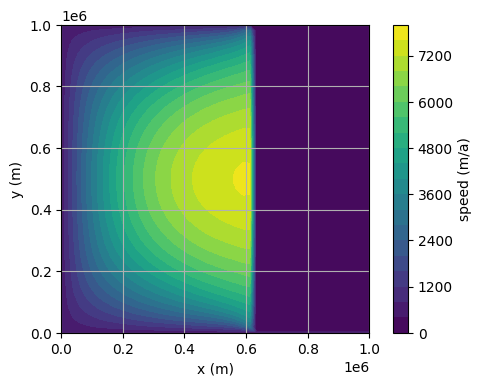

In [6]:
elts = md.mesh.elements - 1
speed_steady = np.hypot(u[0], u[1])

plt.figure(figsize = (6, 4))
plt.tricontourf(x, y, elts, speed_steady, levels = 20)
plt.colorbar(label = 'speed (m/a)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().set_aspect('equal')
plt.grid()
plt.show()

## Transient solution

Also include one calving event. 

In [7]:
model_time = 50
Δt = 1
num_timesteps = int(model_time/Δt)

for step in tqdm.trange(num_timesteps):
    
    u, H, s = coupled_solve(md, Δt, velocity = u, thickness = H, thickness_inflow = H_0)
    # u = diagnostic_solve(md, velocity = u, thickness = H)
    # H, s = prognostic_solve(md, Δt, velocity = u, thickness = H, thickness_inflow = H_0)
    terminus_curve, H, s = advance_terminus(md, Δt, velocity = u, thickness = H, terminus = terminus_curve)
    
    if step == int(num_timesteps/2):
        terminus_curve, H, s = simple_calve(md, thickness = H, surface = s, terminus = terminus_curve, radius = 0.1e6)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.37it/s]


## Plot

Some weird stripey things in the updated thickness curve... why? Not there without terminus advance. 

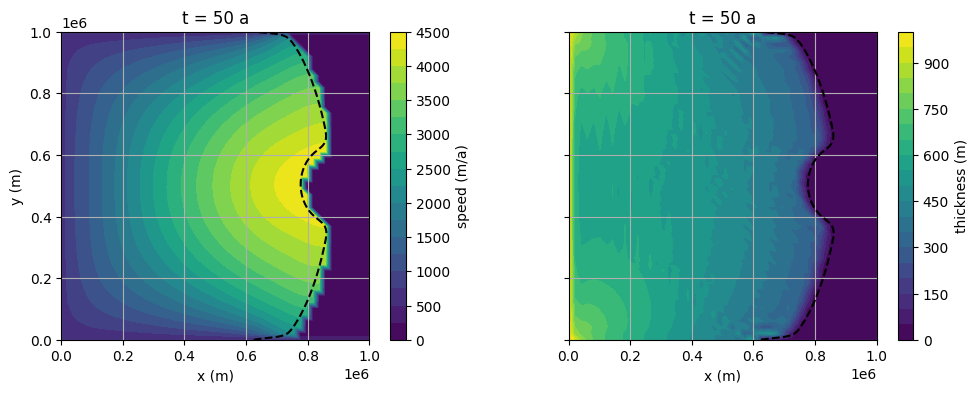

In [8]:
ΔH = H - H_0
vmax = np.max(np.abs(ΔH))
speed = np.hypot(u[0], u[1])
px, py = np.array(terminus_curve.coords).T

fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex = True, sharey = True)

c0 = ax[0].tricontourf(x, y, elts, speed, levels = 20)
ax[0].plot(px, py, color = 'k', linestyle = 'dashed')
fig.colorbar(c0, ax = ax[0], label = 'speed (m/a)')
ax[0].set_title(f't = {model_time:g} a')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')
ax[0].set_aspect('equal')
ax[0].set_ylim(np.min(y), np.max(y))
ax[0].grid()

c1 = ax[1].tricontourf(x, y, elts, H, levels = 20)
ax[1].plot(px, py, color = 'k', linestyle = 'dashed')
fig.colorbar(c1, ax = ax[1], label = 'thickness (m)')
ax[1].set_title(f't = {model_time:g} a')
ax[1].set_xlabel('x (m)')
ax[1].set_aspect('equal')
ax[1].grid()

plt.show()